## Exploratory Data Analysis of SPY weekly prices.

We are going to perform exploratory data analysis on the financial time series formed by SPY weekly closing prices. The goal of this analysis is to see if there are any identifiable patterns or other regularities in the time series data itself. SPY is an ETF (Exchange Traded Fund) which can be thought of as a proxy for S&P500 index. We focus only on the weekly prices excluding any other data which might be useful for price prediction. 

Once a pattern is found, it can be modeled in some way, leading to better understanding as well as identification and analysis of money making and hedging opportunities (e.g. for portfolio management).

In [4]:
%matplotlib notebook

In [5]:
# first, import all the necessary libraries and modules
from __future__ import print_function

import numpy as np               #%matplotlib qt
from pandas import read_csv
from pandas import datetime

import matplotlib.pyplot as plt    #from matplotlib import pyplot

from pandas.plotting import autocorrelation_plot as atp   # from pandas.tools.plotting import autocorrelation_plot

import scipy.stats as stats
import statsmodels.api as stm

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

from pandas import DataFrame
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

from pandas.tools.plotting import lag_plot
from pandas import TimeGrouper

#%%
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')
 
#%%    
# read SPY data (SPY is a S&P500 ETF, which is a proxy of the S&P500 cash index)    
s_tn = read_csv('spy_dt_wk_1993_2017.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)  #, date_parser=parser
p_t=s_tn['Close']     # just get the closing prices
print(s_tn.head())


            Time   Open   High    Low  Close      Vol
Date                                                 
1993-02-05  1600  44.23  45.10  44.13  44.97  1754300
1993-02-12  1600  44.97  45.13  44.53  44.60  1159800
1993-02-19  1600  44.47  44.47  42.82  43.57   998700
1993-02-26  1600  43.70  44.44  43.48  44.42  1024300
1993-03-05  1600  44.56  45.20  44.23  44.75   658500


Let us plot a regular price vs time figure to understand the overall behaviour and check for any anomalies.

<IPython.core.display.Javascript object>


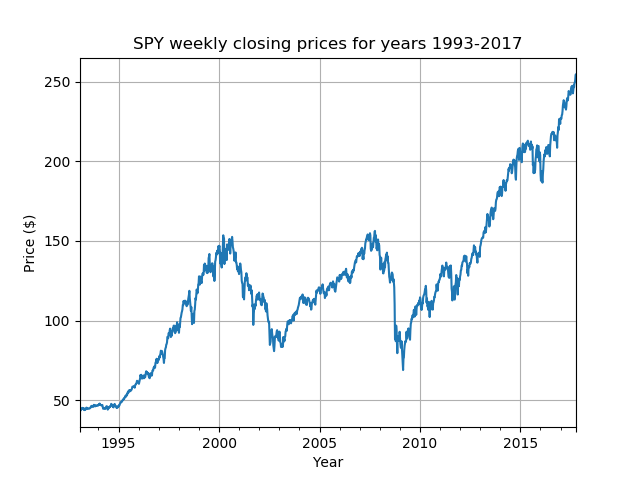

In [6]:
#%%
# plot the price of SPY ETF time series p_t
fig1 = plt.figure()       #ax1 = fig1.add_subplot(111)  #ax1.plot(p_t)

p_t.plot()     #plt.show()
plt.title('SPY weekly closing prices for years 1993-2017')
plt.ylabel('Price ($)')
plt.xlabel('Year')
plt.grid(True)
plt.show()

From the figure above, one may notice that the time series is non-stationary. It exhibits trending behaviour. One of the two requirements of weak stationarity is that the mean be independent of time. The plot above clearly shows that this is not the case. The second requirement says that covariance of returns $Cov(r_t, r_{t−l}) = γ_l $ should depend only on the time difference in lag, $ l $, and not on the time itself. Let us examine this more closely by calculating and plotting a series of returns $r_t$. 

<IPython.core.display.Javascript object>


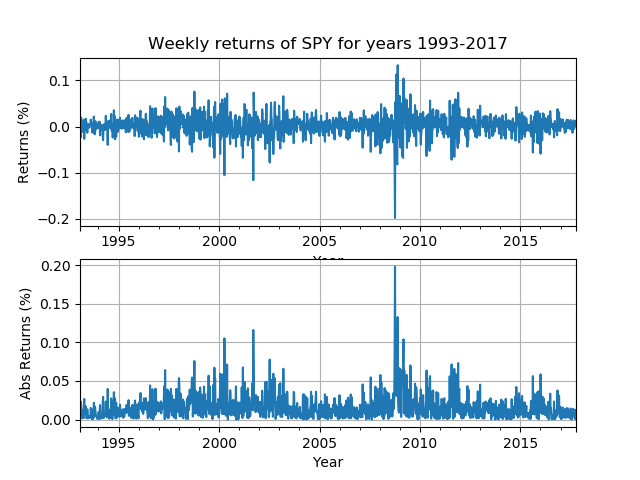

In [7]:
#%%
# calculate return series and plot it
pr_t=p_t.pct_change(1)

#%%
fig2 = plt.figure()
plt.subplot(2, 1, 1)
pr_t.plot()         # .abs()

plt.title('Weekly returns of SPY for years 1993-2017')
plt.ylabel('Returns (%)')
plt.xlabel('Year')
plt.grid(True)

plt.subplot(2, 1, 2)
pr_t.abs().plot()         # 

#plt.title('Weekly absolute returns of SPY for years 1993-2017')
plt.ylabel('Abs Returns (%)')
plt.xlabel('Year')
plt.grid(True)
plt.show()

Let us examine the plots above. We see that the returns have a mean reverting behaviour, since they oscillate around 0 mean. However, the amplitude of the oscillations is not constant, something we would expect for a stationary series. Instead, the amplitude exhibits clustering. Large amplitude spikes are followed by similarly large spikes, and short spikes follow short spikes. This can be better seen in the plot of absolute returns (second panel). We will come back to this important point later.

Now, let us turn our attention to the autocorrelation function (ACF). First, look at the ACF of prices.

<IPython.core.display.Javascript object>


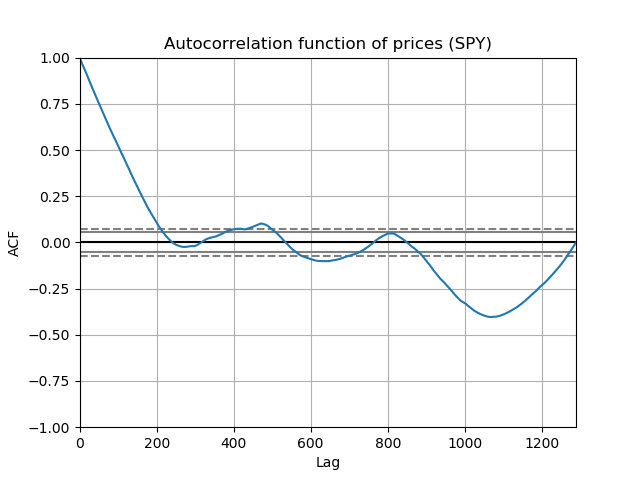

In [8]:
#%%
# plot autocorrelation function of p_t s_tn
fig3 = plt.figure()    # ax2 = fig2.add_subplot(111)
atp(p_t)               #plt.show()

plt.title('Autocorrelation function of prices (SPY)')
plt.ylabel('ACF')
plt.xlabel('Lag')
plt.grid(True)
plt.show()

One can see that, that ACF of prices exhibits non-zero auto-correlation for lags up to 200, therefore hinting at linear time dependence in the time series. However, if there is non-zero auto-correlation at lag 1, it will propagate through higher time lags, contaminating the specific influence of the other lags. So, we have to examine a partial auto-correlation function, PACF, which eliminates such influence and shows the effect of each specific lag. The plot of PACF is shown below, where the blue band around 0 indicates a 95% confidence interval.

<IPython.core.display.Javascript object>


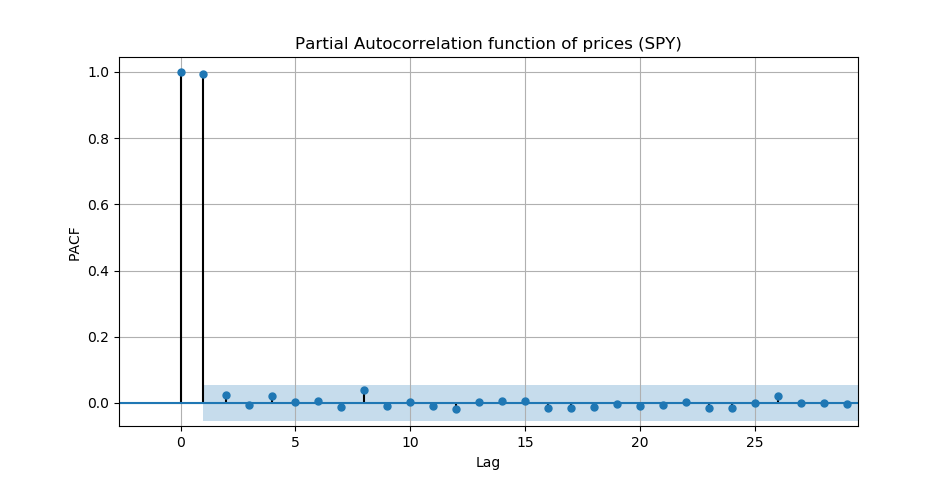

In [9]:
#%%
# plot partial autocorrelation function of the series p_t
#fig4 = plt.figure()
plot_pacf(p_t, lags=500)

plt.title('Partial Autocorrelation function of prices (SPY)')
plt.ylabel('PACF')
plt.xlabel('Lag')
plt.grid(True)
plt.show()

We see that the PACF shows only two non-zero auto-correlation coefficients, at lags 0 and 1, meaning that 
there is no linear time dependence in the series of returns (after differencing the price series). However, let us look at the coefficients at all lags more carefully. 

<IPython.core.display.Javascript object>


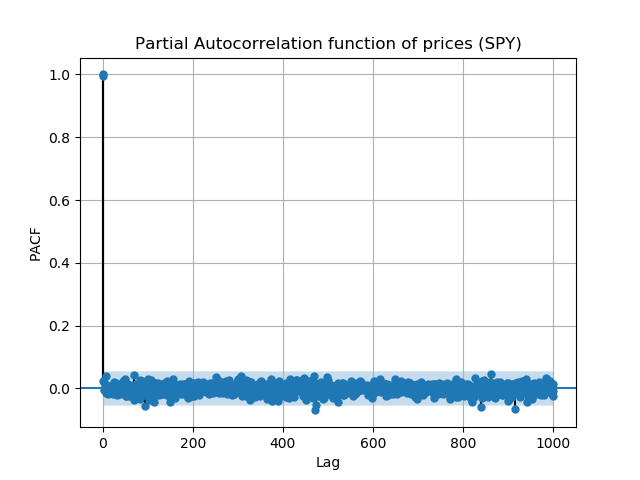

In [15]:
# plot partial autocorrelation function of the series p_t
#fig4 = plt.figure()
plot_pacf(p_t, lags=1000)

plt.title('Partial Autocorrelation function of prices (SPY)')
plt.ylabel('PACF')
plt.xlabel('Lag')
plt.grid(True)
plt.show()

Interestingly, there seems to be non-zero (negative) coefficients at lags around 90, 470, 840, 920. They may indicate attraction/repulsion effects at certain price levels, perhaps, showing that proximity of current price to past price pivots (inflection points) is important. We will return to this point later. 

For completeness, we also produce a lag plot of prices at lag 1 below.

<IPython.core.display.Javascript object>


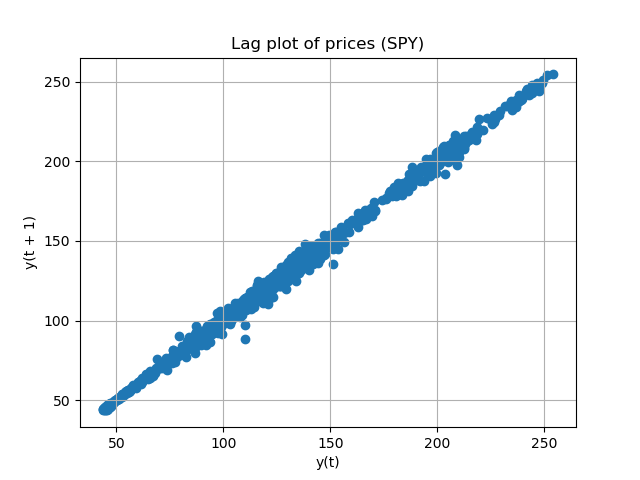

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 'pandas.tools.plotting.lag_plot' is deprecated, import 'pandas.plotting.lag_plot' instead.
  after removing the cwd from sys.path.


In [12]:
#%%
# plot a lag plot of the series p_t
fig5 = plt.figure()
lag_plot(p_t)       # this is a lag plot with 1-step lag

plt.title('Lag plot of prices (SPY)')
plt.grid(True)
plt.show()

One interesting observation from this lag 1 plot is that the variance does not seem to be proportional to the mean. We observe that the vertical spread does grow when $y(t)$ increases from 50 to 150. However, it then oscillates when $y(t)$ goes from 150 to 250: it shrinks from 160 to 180, then widens till 220, narrows to 240, then widens again. This observation is consistent with the current volatility regime in the S&P500 futures market. Due to prevalence of participants in the short volatility trade, the volatility index VIX has never been lower, indicating historically low volatility while prices are making new highs.

Since the final goal is to identify trading opportunities, we have to shift our attention to time series of returns. The ACF of returns is plotted below. 

<IPython.core.display.Javascript object>


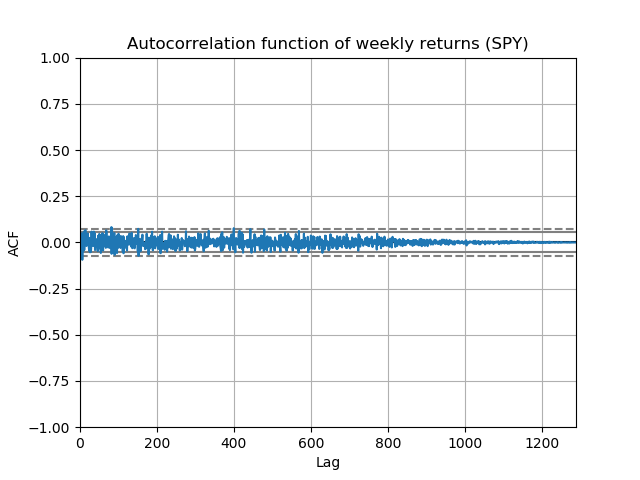

In [11]:
# plot autocorrelation function of pr_t  
fig6 = plt.figure()    
atp(pr_t[1:])               

plt.title('Autocorrelation function of weekly returns (SPY)')
plt.ylabel('ACF')
plt.xlabel('Lag')
plt.grid(True)
plt.show()

All of the auto correlation coefficients with lag $l > 0$ are zero with 95% confidence, implying lack of linear time dependence.

<IPython.core.display.Javascript object>


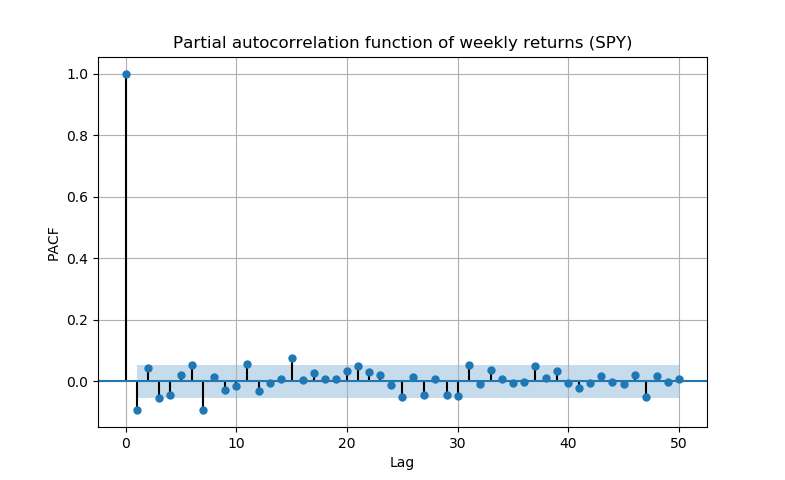

In [39]:
plot_pacf(pr_t[1:], lags=50)

plt.title('Partial autocorrelation function of weekly returns (SPY)')
plt.ylabel('PACF')
plt.xlabel('Lag')
plt.grid(True)
plt.show()

We can draw a similar conclusion by looking at the PACF function of returns above. 

Now, let us check the lag plot of returns.

<IPython.core.display.Javascript object>


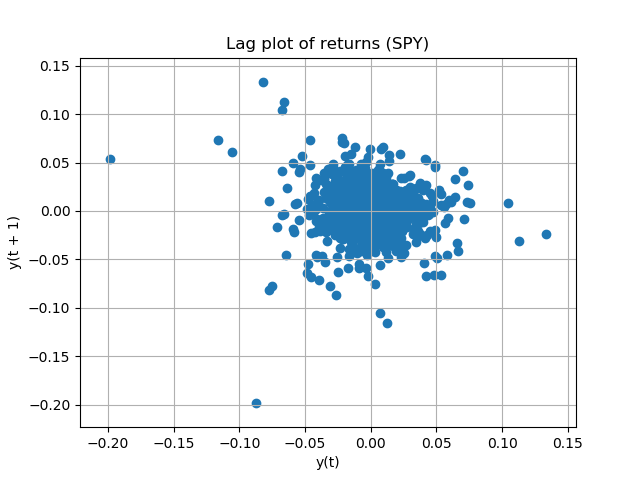

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.lag_plot' is deprecated, import 'pandas.plotting.lag_plot' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
# plot a lag plot of the returns pr_t
fig7 = plt.figure()
lag_plot(pr_t)       # this is a lag plot with 1-step lag

plt.title('Lag plot of returns (SPY)')
plt.grid(True)
plt.show()

There is certainly some kind of non-linear structure in the lag 1 plot above. If the series were purely random, it would fill a circular blob. Instead, we see that the blob is alongated and has multiple outliers. So, we can examine the distribution of returns. First, let us look at the histogram.

<IPython.core.display.Javascript object>


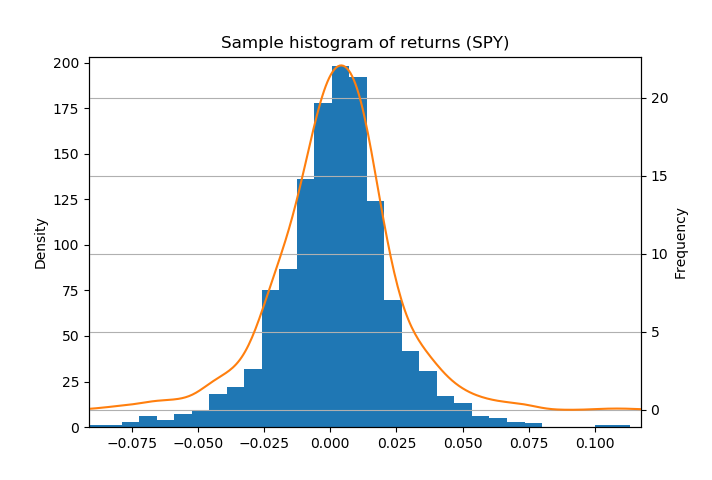

In [12]:
# plot a sample histogram
fig8 = plt.figure()
ax1 = pr_t.plot(kind='hist', bins=50)    #.hist(bins=50)        # plt.hist(pr_t,50)      #

pr_t.plot(kind='kde', ax = ax1, secondary_y=True)   # plot the probability density estimate

plt.title('Sample histogram of returns (SPY)')
plt.ylabel('Frequency')
plt.xlabel('Return (%)')
plt.grid(True)

While it is clear that the histogram is not symmetric and has outliers sufficiently far in the tail, we will get a better understanding of the distribution function by looking at the Q-Q plot.

<IPython.core.display.Javascript object>


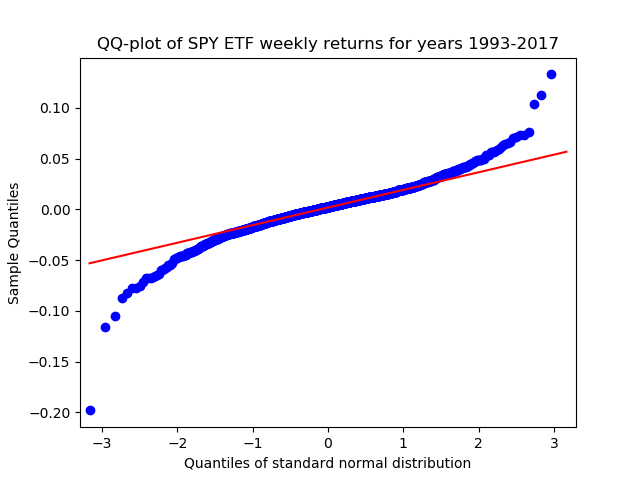

In [23]:
# make a qq-plot against a standard distribution of some type
#fig9 = plt.figure()
stm.qqplot(pr_t, line='q')    # , stats.t, distargs=(5,) #, line='45' 

plt.title('QQ-plot of SPY ETF weekly returns for years 1993-2017')
plt.xlabel('Quantiles of standard normal distribution')

Blue dots are quantiles of our sample distribution, red line follows standard normal quantiles. We can see that there are substantial deviations in the tails, indicating that the distribution of returns is not normal and has fat tails. Fat tail events correspond to large returns in comparison to what a normal distribution would predict. This may imply some sort of nonlinear dependences in the time series. 

In [18]:
# group the price series by years to compare performance between different years
gp_y = p_t.groupby(TimeGrouper('A'))    # '_y'=by-year, 'gp'=group-by-object of price
Nw=gp_y.size().max()                    # max nr of weeks across all years in gp_y

p_ty = DataFrame(index=range(0,Nw))   # i need to have same _t sizes for all years in _y   #.reindex_like()
for name, group in gp_y:
   p_w = group.values                 # '_w'=week  # p_w.size
   
   if Nw > p_w.size :                         # need to have same sizes for all years
      dp = np.full((1,Nw - p_w.size),np.nan)
      p_w = np.append(p_w,dp)                 # pad p_w until we get it to size Nw 
   # end if
   
   p_w = (p_w - p_w[0])/p_w[0]     #p_w - p_w[0]  # subtract first element to compare different years      
   p_ty[name.year] = p_w           #print(name)  #group.size
# end for name, group
   

<IPython.core.display.Javascript object>


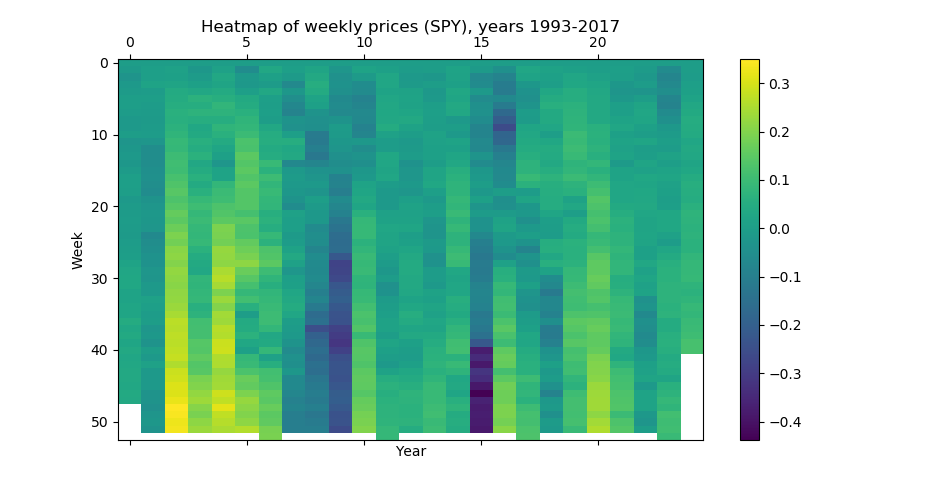

In [20]:
# plot time series heatmap   
fig12 = plt.figure()
ax = fig12.add_subplot(111)
cax = ax.matshow(p_ty, interpolation=None, aspect='auto')   # 'hot' , cmap='jet'

fig12.colorbar(cax)

plt.title('Heatmap of weekly prices (SPY), years 1993-2017')
plt.ylabel('Week')
plt.xlabel('Year')
plt.show()

<IPython.core.display.Javascript object>


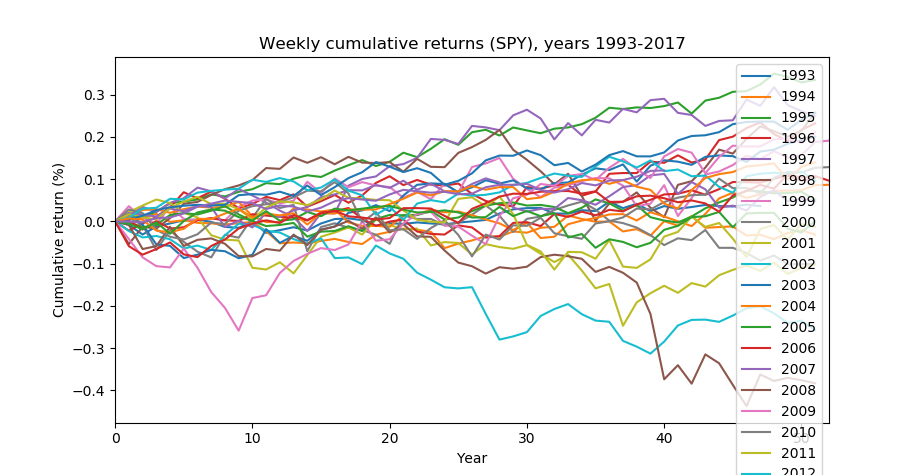

In [22]:
#fig13 = plt.figure()
p_ty.plot()

plt.title('Weekly cumulative returns (SPY), years 1993-2017')
plt.ylabel('Cumulative return (%)')
plt.xlabel('Year')

<IPython.core.display.Javascript object>


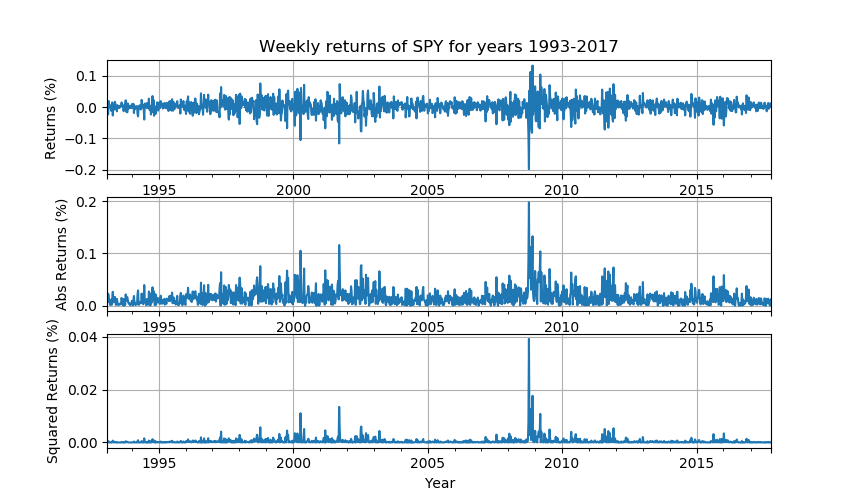

In [24]:
# let us square our returns
pr2_t=pr_t.apply(lambda x: x**2)
#%%
fig15 = plt.figure()
plt.subplot(3, 1, 1)
pr_t.plot()         # .abs()

plt.title('Weekly returns of SPY for years 1993-2017')
plt.ylabel('Returns (%)')
plt.xlabel('Year')
plt.grid(True)

plt.subplot(3, 1, 2)
pr_t.abs().plot()         # 

#plt.title('Weekly absolute returns of SPY for years 1993-2017')
plt.ylabel('Abs Returns (%)')
plt.xlabel('Year')
plt.grid(True)

plt.subplot(3, 1, 3)
pr2_t.plot() 
plt.ylabel('Squared Returns (%)')
plt.xlabel('Year')
plt.grid(True)

<IPython.core.display.Javascript object>


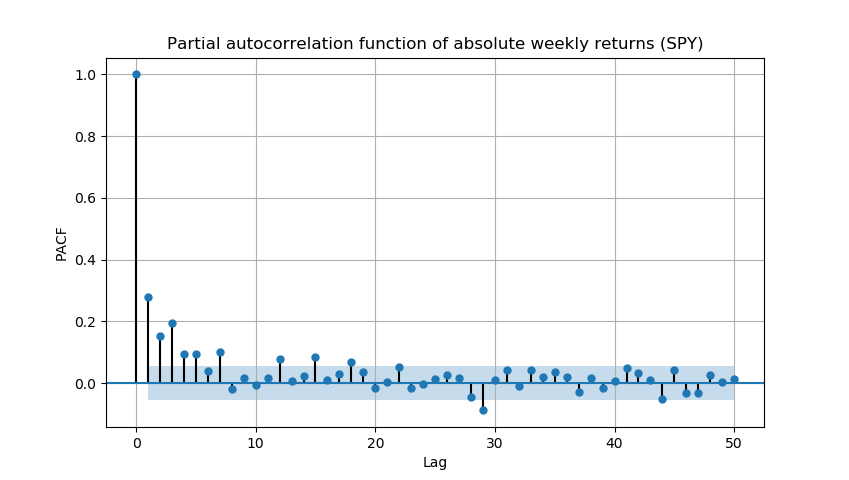

In [38]:
# plot autocorrelation function of absolute returns abs(pr_t)  
#fig16 = plt.figure()    
plot_pacf(pr_t[1:].abs(), lags=50)    # atp(pr_t.abs())      plot_pacf    , lags=50     

plt.title('Partial autocorrelation function of absolute weekly returns (SPY)')
plt.ylabel('PACF')
plt.xlabel('Lag')
plt.grid(True)

The above PACF of absolute returns clearly shows time dependence at multiple lags, strongly suggesting that such nonlinearity is important for prediction of future returns. This further implies that we are dealing with a financial time series which is non random and thus can be predicted, albeit by understanding its non linear nature. It is subject for further research.

Let us come back to potential long range correlations in the price series shown in the PACF plot above. Auto-correlation function of a time series is based upon notion of proximity in time. By construction, it silently implies  that the most recent history is more important than the very distant past. However, it does not place correct emphasis on proximity in price, or rather, to pivot points at certain price levels. Such pivot points may reflect certain historical events, thus forming important milestones in collective perception of the fair value. Therefore, I propose to study a two dimensional price-pivot ACF (call it PR-ACF) based on price and time proximity. It may describe financial time series non-linearities better than a standard ACF by incorporating both time and price lag coefficients together. 

Therefore, long range correlations may be described by just a few price lag coefficients in PR-ACF (as opposed to many time lag coefficients of the standard ACF), thus leading to dimensionality reduction. It is important to note that, such correlations should not be thought of as waves with long wavelength, because they do not have to imply true time periodicity. Rather, they would show dependency on the price proximity, whenever such proximity occurs.

We may think of fat tails as being formed by multiple extreme events, each event being produced by unlikely coherency (accumulation) between sub-events. Under normality assumption, all sub-events are independent of each other, therefore, having a long string of sub-events of the same sign is very unlikely. However, we have to keep in mind that, financial time series is just a reflection of human, business affairs, and human collective psychology. Humans tend to have inertia in their way of acting, thinking and reacting to the outside world. Therefore, it seems likely that such inertia would lead to market inertia which would tend to produce long strings of sub-events of the same sign quite regularly. So, it is natural to expect fat tails in the distribution of financial time series. Mathematically, fat tail distributions have a power law dependency as opposed to exponential tails of normal distribution.

To understand better, what kinds of sub-events are important and are likely to produce a mutliple sigma fat tail event, we have to examine financial history of bear markets and market crashes. For example, in the years 2003-2006 Federal Reserve started to raise interest rates agressivly, removing liquidity from the markets already addicted to liquidity. We may interpret this as one such aforementioned series of sub-events (clearly, not independent, all related to each other), culminating in the financial crash of 2008 (which is but one example of fat tail events).

By the same token, even the market reaction to the financial and business conditions in 2007-2008 may be described as a series of sub-events, each sub-event being the price movement over a certain time period. The early onset of the crisis was not apparent to most market participants, thus not resulting in the immediate crash at the very top. It took time for this realization to spread, bringing a series of news reflecting the situation over a period of several weeks and months, preceding Lehman Brothers collapse. Given the severity of the situation at that time, these news could not have been a mixture of equally good and bad news. They were all bad news, i.e. sub-events of the same sign, resulting in a significant (multiple sigma) price  drop. At the same time, there was no regulatory response, since there was a substantial risk of error for regulators to act too early too strongly.

The initial price drop and subsequent Lehman collapse lead to a strong regulatory response, but it was too little, too late. Parade of bad news continued (partly reflecting the damage of the price collapses across the board) as well as price slides, resulting in a snow ball effect. 

From this discussion, we may conclude that some type of non-linear dependency is the cause of fat tail events. Therefore, understanding and modeling such non-linearities could be the foundation of successful prediction of multiple sigma events, which is an integral part of financial time series prediction in general.